# Road Signs classification

---

## 1. Environment Preparation

In [62]:
import tensorflow as tf

# List all physical devices (including GPUs)
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    print(f"GPUs detected: {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {gpu}")
else:
    print("No GPU detected.")

GPUs detected: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [63]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import randint
import matplotlib.pyplot as plt
import tensorflow.keras as keras

random_seed = 42

In [64]:
train_data_path = "Data/archive/"
image_size = (64, 64)

---

## 2. Data Preprocessing

### A. Data Loading

In [65]:
def load_data(meta_data, data_path, image_size, is_test=False):
    Y = (
        keras.utils.to_categorical(meta_data["ClassId"])
        if not is_test
        else meta_data["ClassId"]
    )
    X = np.array(
        [
            np.array(
                cv2.resize(cv2.imread(data_path + path)[..., ::-1], image_size),
                dtype=np.float64,
            )
            for path in tqdm(meta_data.Path)
        ]
    )
    return X, Y

In [66]:
train_meta_data = pd.read_csv("Data/archive/Train.csv")
train_meta_data = train_meta_data[["ClassId", "Path"]]
X, Y = load_data(train_meta_data, train_data_path, image_size)

100%|██████████| 39209/39209 [00:22<00:00, 1728.40it/s]


In [67]:
X.shape, Y.shape

((39209, 64, 64, 3), (39209, 43))

In [68]:
train_meta_data.ClassId.unique()

array([20,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42])

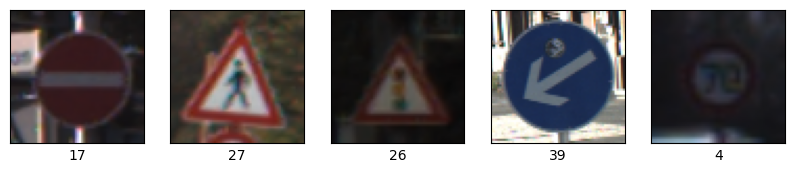

In [69]:
def plot_random_samples(meta_data, X):
    fig, axes = plt.subplots(1, 5, figsize=(10, 5))
    for i in range(5):
        n = randint(0, len(X))
        axes[i].imshow(X[n] / 255)
        axes[i].set_xlabel((meta_data.ClassId.iloc[n]))
        axes[i].set_xticks(()), axes[i].set_yticks(())
    plt.show()


plot_random_samples(train_meta_data, X)

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=random_seed,
    # stratify=Y,
)

In [71]:
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((31367, 64, 64, 3), (7842, 64, 64, 3), (31367, 43), (7842, 43))

### B. Data Augmentation

In [72]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    rotation_range=10,
    brightness_range=[0.9, 1.1],
)
it_train = train_datagen.flow(X_train, Y_train, batch_size=64)
it_val = train_datagen.flow(X_val, Y_val, batch_size=64)

---

## 3. Model Building & Compiling

In [73]:
from keras.models import Sequential
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Rescaling,
    Input,
)


model = Sequential(
    [
        Input(shape=(64, 64, 3)),
        Rescaling(1.0 / 255.0),
        Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(units=256, activation="relu"),
        Dropout(0.5),
        Dense(units=43, activation="softmax"),
    ]
)


print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 31, 31, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,779 (940.54 KB)

 Trainable params: 240,299 (938.67 KB)

 Non-trainable params: 480 (1.88 KB)

None


In [74]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [75]:
earlystop = keras.callbacks.EarlyStopping(patience=4)

history = model.fit(it_train, validation_data=it_val, epochs=30, callbacks=[earlystop])

Epoch 1/30


/mnt/Files/Sorbonne_Data_Analytics_SDA/Cours/Deep_Learning_Dafnis-Krasniqi/Road_Signs_Deep_Learning_Classification/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/491 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.4325 - loss: 2.1327 - val_accuracy: 0.7605 - val_loss: 0.7844
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 32s 65ms/step - accuracy: 0.9014 - loss: 0.3141 - val_accuracy: 0.9661 - val_loss: 0.1109
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.9541 - loss: 0.1498 - val_accuracy: 0.9793 - val_loss: 0.0744
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.9703 - loss: 0.0994 - val_accuracy: 0.9834 - val_loss: 0.0537
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.9766 - loss: 0.0745 - val_accuracy: 0.9875 - val_loss: 0.0425
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.9769 - loss: 0.0745 - val_accuracy: 0.9867 - val_loss: 0.0396
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.9797 - loss: 0.0615 - val_accuracy: 0.9904 - val_loss: 0.0315
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.9833 - loss: 0.0492 - val_accurac

Max val_acc 0.9924764037132263


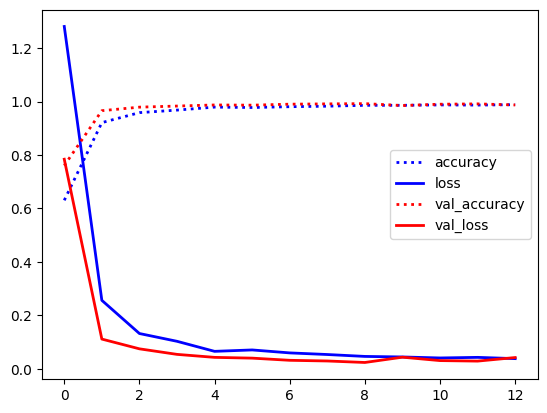

In [76]:
import pandas as pd
import numpy as np

pd.DataFrame(history.history).plot(lw=2, style=["b:", "b-", "r:", "r-"])
print("Max val_acc", np.max(history.history["val_accuracy"]))

---

## 4. Model Evaluation

In [77]:
test_data_path = "Data/archive/"
test_meta_data = pd.read_csv("Data/archive/Test.csv")
test_meta_data = test_meta_data[["ClassId", "Path"]]
X_test, Y_test = load_data(test_meta_data, test_data_path, image_size, is_test=True)

100%|██████████| 12630/12630 [00:06<00:00, 2065.86it/s]


In [78]:
X_test.shape, Y_test.shape

((12630, 64, 64, 3), (12630,))

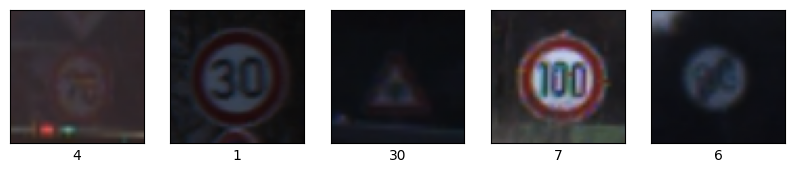

In [79]:
plot_random_samples(test_meta_data, X_test)

In [80]:
pred = model.predict(X_test, verbose=1)

2024-10-03 01:58:01.814019: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 620789760 exceeds 10% of free system memory.
2024-10-03 01:58:02.448897: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 620789760 exceeds 10% of free system memory.


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [81]:
pred.shape

(12630, 43)

In [117]:
Y_pred = np.argmax(pred, axis=1)
Y_pred[:5]

array([16,  1, 38, 33, 11])

In [118]:
Y_test

0        16
1         1
2        38
3        33
4        11
         ..
12625    12
12626    33
12627     6
12628     7
12629    10
Name: ClassId, Length: 12630, dtype: int64

In [119]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
)

print(classification_report(Y_test, Y_pred))
print("Accuracy: ", accuracy_score(Y_test, Y_pred))
print(
    "Precision: ", precision_score(Y_test, Y_pred, average="weighted")
)
print("Recall: ", recall_score(Y_test, Y_pred, average="weighted"))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.96      1.00      0.98       720
           2       0.93      0.99      0.96       750
           3       1.00      0.89      0.94       450
           4       1.00      0.96      0.98       660
           5       0.91      0.98      0.94       630
           6       0.87      1.00      0.93       150
           7       1.00      0.99      0.99       450
           8       0.99      0.98      0.98       450
           9       0.98      1.00      0.99       480
          10       1.00      1.00      1.00       660
          11       0.97      1.00      0.98       420
          12       0.97      1.00      0.98       690
          13       0.98      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       1.00      0.76      0.86       210
          16       1.00      1.00      1.00       150
          17       1.00    

In [120]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, Y_pred)

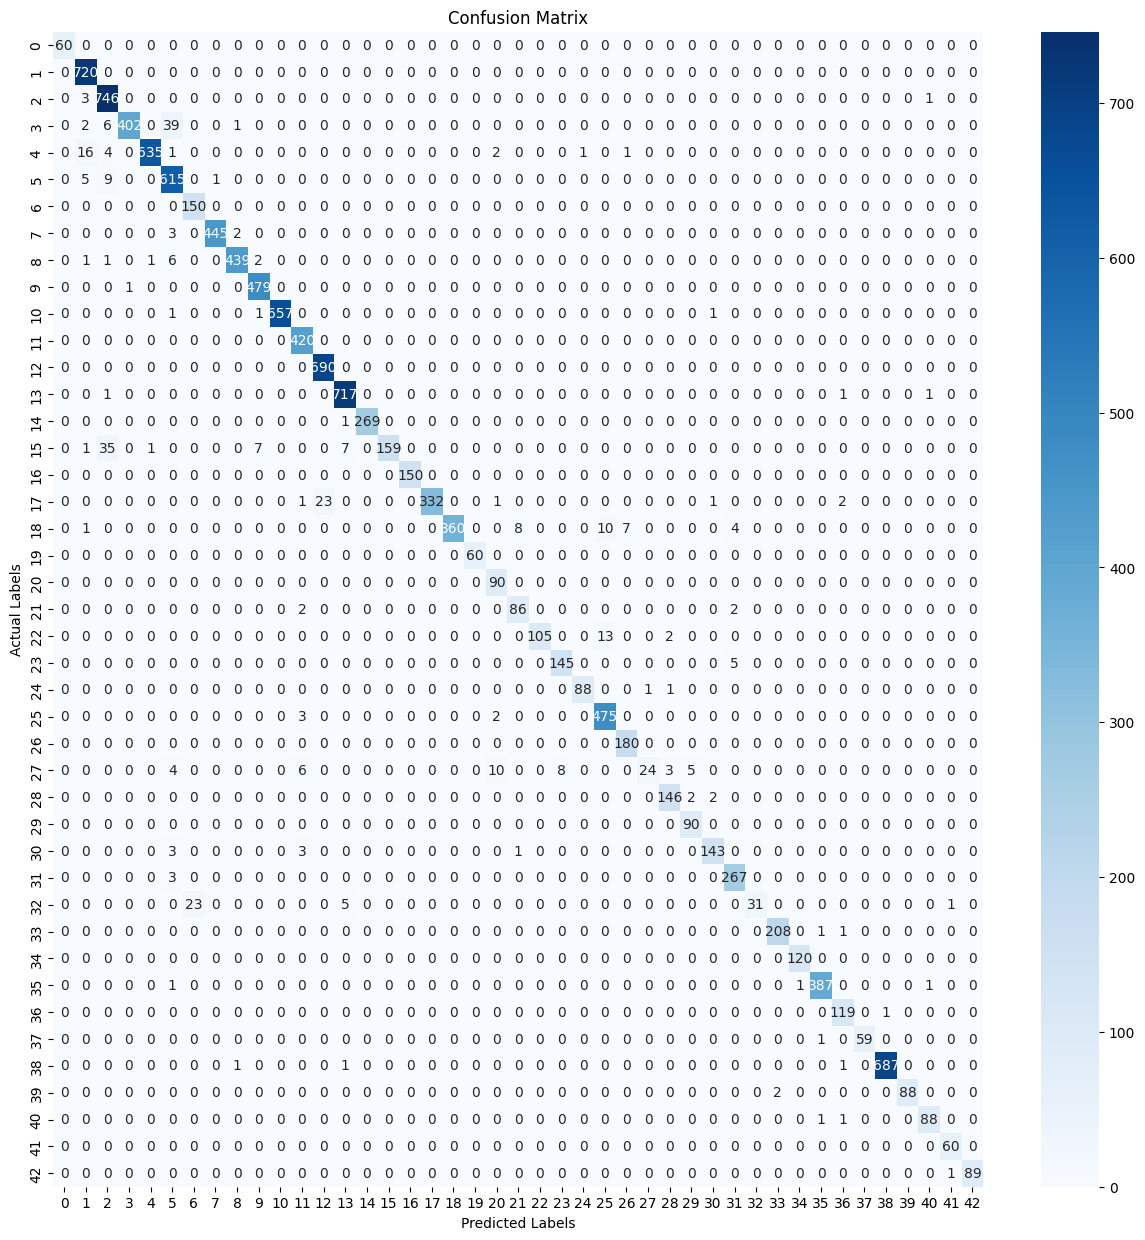

In [121]:
import seaborn as sns

plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

---

## 5. Interpretation

### A. Misclassification

In [128]:
Y_test.shape,Y_pred.shape

((12630,), (12630,))

In [136]:
misclassified_samples = np.nonzero(Y_test != Y_pred)[0]
misclassified_samples

array([   39,    52,    64,   114,   131,   159,   176,   197,   237,
         339,   371,   492,   496,   550,   576,   604,   650,   677,
         760,   776,   796,   820,   829,   904,   952,  1034,  1119,
        1150,  1317,  1364,  1431,  1475,  1477,  1553,  1560,  1573,
        1676,  1682,  1694,  1706,  1709,  1774,  1966,  1969,  2017,
        2025,  2065,  2068,  2109,  2119,  2157,  2176,  2191,  2232,
        2342,  2376,  2397,  2494,  2496,  2518,  2538,  2577,  2629,
        2725,  2728,  2748,  2818,  2836,  2847,  2898,  2907,  2918,
        2948,  2949,  2996,  3101,  3172,  3173,  3241,  3250,  3296,
        3322,  3343,  3402,  3448,  3485,  3553,  3562,  3564,  3577,
        3630,  3644,  3655,  3739,  3819,  3824,  3846,  3873,  3898,
        3907,  3938,  3960,  4211,  4219,  4265,  4267,  4269,  4279,
        4294,  4306,  4449,  4456,  4561,  4562,  4575,  4579,  4585,
        4588,  4601,  4658,  4767,  4777,  4783,  4794,  4803,  4863,
        4868,  4892,

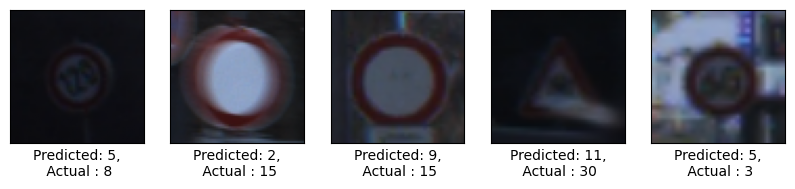

In [142]:
# Visualize the (first five) misclassifications, together with the predicted and actual class
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for nr, i in enumerate(misclassified_samples[:5]):
    axes[nr].imshow(X_test[i]/255.0)
    axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (Y_pred[i],Y_test[i]))
    axes[nr].set_xticks(()), axes[nr].set_yticks(())

plt.show()